# K-means кластеризация

### Описание алгоритма 
1. Arbitrarily choose an initial $k$ centers $C=\{c_1, c_2,···, c_k\}$.
2. For each $i \in \{1, . . . , k\}$, set the cluster $C_i$ to be the set of points in $X$ that are closer to $c_i$ than they are to $c_j$ for all $j\neq i$.
3. For each $i \in \{1, . . . , k\}$, set $c_i$ to be the center of mass of all points in $C_i: c_i=\frac{1}{|C_i|} \sum_{x \in C_i}{x}$.
4. Repeat Steps 2 and 3 until $C$ no longer changes.

### Импортируем нужные библиотеки
Pandas - для удобной работы с данными, matplotlib - для визуализации, numpy - для математики

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

### Cчитаем данные в DataFrame

In [2]:
data = pd.read_csv('lab3Train.csv', index_col=0)
#вывести пять случайных строк таблицы
data.sample(10)

,x,y
15,107,2
30,55,0
6,112,4
19,100,3
3,110,5
8,95,3
22,70,-1
36,65,0
9,90,3
32,45,-1


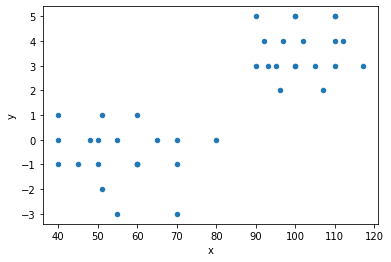

In [3]:
#параметр scatter для графиков рассеяния
data.plot(kind='scatter', x='x', y='y')
plt.show()

### K-means++ 
Суть улучшения заключается в нахождении более «хороших» начальных значений центроидов кластеров:
1. Выбрать первый центроид случайным образом (среди всех точек)
2. Для каждой точки найти значение квадрата расстояния до ближайшего центроида (из тех, которые уже выбраны) dx²
3. Выбрать из этих точек следующий центроид так, чтобы вероятность выбора точки была пропорциональна вычисленному для неё квадрату расстояния. Это можно сделать следующим образом. На шаге 2 нужно параллельно с расчётом dx² подсчитывать сумму Sum(dx²). После накопления суммы найти значение Rnd=random(0.0,1.0)*Sum. Rnd случайным образом укажет на число из интервала [0; Sum), и нам остаётся только определить, какой точке это соответствует. Для этого нужно снова начать подсчитывать сумму S(dx²) до тех пор, пока сумма не превысит Rnd. Как только это случится, суммирование останавливается, и мы можем взять текущую точку в качестве центроида.
При выборе каждого следующего центроида специально следить за тем, чтобы он не совпал с одной из уже выбранных в качестве центроидов точек, не нужно, так как вероятность повторного выбора некоторой точки равна 0.
4. Повторять шаги 2 и 3 до тех пор, пока не будут найдены все необходимые центроиды.

In [4]:
# Функция для нахождения центроид по алгоритму k-means++
def c_init_kmeans_plusplus(x, y, k): 
#     выбираем первый центроид случайным образом из всех точек
    random_index = random.randint(0, len(x) - 1)
    c_x = []
    c_y = []
    c_x.append(x[random_index])
    c_y.append(y[random_index])
#     до тех пора, пока не будут найдены все необходимые центроиды
    while (k-1) > 0: 
        dx2 = []
#         для всех точек
        for point_x, point_y in zip(x,y):
            euclidean_dist = []
            for cent_x, cent_y in zip(c_x,c_y):
#                 считаем евклидово расстояние до всех центроид
                dist = (cent_x - point_x) ** 2 + (cent_y - point_y)**2
                euclidean_dist.append(dist)
#             в список расстояний добавляем расстояние до ближайшей центроиды
            dx2.append(min(euclidean_dist))
#         находим сумму расстояний
        Sum = np.sum(dx2)
#         случайное число из интервала [0;Sum)
        Rnd = random.random()*Sum
        Sum_new = -1
#         пересчитываем сумму расстояний
        for i in range(len(dx2)):
#             до тех пор, пока не превысит найденное случайное число
            if Sum_new <= Rnd:
                Sum_new += dx2[i]
            else: 
#                 берем текущую точку в качестве следующего центроида
                c_x.append(x[i])
                c_y.append(y[i])
                break 
        k -= 1
    return c_x, c_y

In [5]:
# Функция для нахождения центроид - двух случайных точек из выборки
def c_init_kmeans(x, y, k): 
    c_x = []
    c_y = []
    for _ in range(k):
        random_index = random.randint(0, len(x) - 1)
        c_x.append(x[random_index])
        c_y.append(y[random_index])
        x.pop(random_index)
        y.pop(random_index)
    return c_x, c_y

In [6]:
# Вызываем функцию для нахождения начальных значений центроид
# c_x, c_y = c_init_kmeans(data['x'].tolist(),data['y'].tolist(),2)
c_x, c_y  = c_init_kmeans_plusplus(data['x'].tolist(),data['y'].tolist(),2)

### Выводим найденые центроиды на график 

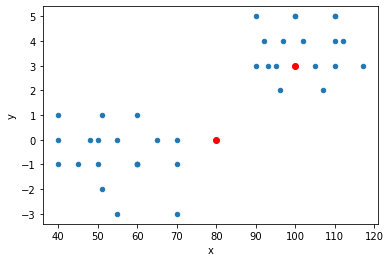

In [7]:
data.plot(kind='scatter', x='x', y='y')
plt.plot(c_x, c_y, 'ro', linewidth=2)
plt.show()

### Реализация K-Means Clustering  

In [8]:
# На вход принимаем данные из датасета, количество класстеров и начальные центроиды
def train_k_means_clustering (x, y, k, c_x, c_y):
    c_x_old = []
    c_y_old = []
#     пока центроиды отличаются
    while c_x != c_x_old and c_y != c_y_old: 
        c_x_old = c_x
        c_y_old = c_y
        answers = []
#         проходимся по точкам и считаем евклидово расстояние
        for point_x, point_y in zip(x,y):
            euclidean_dist = []
            for cent_x, cent_y in zip(c_x,c_y):  
                dist = ((cent_x - point_x) ** 2 + (cent_y - point_y) ** 2) ** (1/2)
                euclidean_dist.append(dist) 
#             В столбец ответов записываем индекс массива - с расстояниями от точки до центроид
#             с наименьшим значением расстояния. Это будет названием класса для точки. 
            answers.append(np.argmin(euclidean_dist))
#         обновляем значение центроид
        c_x = []
        c_y = []
#         проходим по классам
        for i in range(k): 
            sum_x = 0 
            sum_y = 0 
#             пробегаем по строкам с точками
            for j in range(len(answers)): 
#                 если значение из класса, который мы сейчас рассматриваем - прибавляем к сумме
                if answers[j] == i: 
                    sum_x += x[j] 
                    sum_y += y[j]
#             находим итоговое значение новых центроид
            c_x.append(1 / answers.count(i) * sum_x)
            c_y.append(1 / answers.count(i) * sum_y)
    return c_x, c_y, answers          

In [9]:
# вызываем функцию кластеризации
C_x, C_y, answer = train_k_means_clustering(data['x'].tolist(), data['y'].tolist(), 2, c_x, c_y)
# вставляем полученный столбец ответов в таблицу
data.insert(len(data.columns), "Answer", answer, False)
#вывести пять случайных строк таблицы
data.sample(10)

,x,y,Answer
36,65,0,0
8,95,3,1
11,110,5,1
17,96,2,1
5,102,4,1
32,45,-1,0
15,107,2,1
22,70,-1,0
6,112,4,1
26,80,0,1


### Визуализируем найденные кластеры

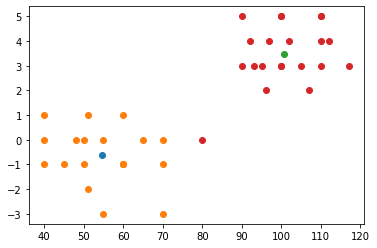

In [10]:
for i in range(2):
    X = data.loc[data['Answer'] == i]['x'].tolist()
    Y = data.loc[data['Answer'] == i]['y'].tolist()
    plt.plot(C_x[i],C_y[i],'o')
    plt.plot(X,Y, 'o')
plt.show()

### Загружаем тестовую выборку

In [11]:
# считаем данные в DataFrame
data_test = pd.read_csv('lab3Test.csv', index_col=0)
data_test.head(7)

,x,y
1,40,-2.0
2,50,2.0
3,106,4.5
4,85,2.0
5,110,1.0
6,80,-2.0
7,120,-3.0


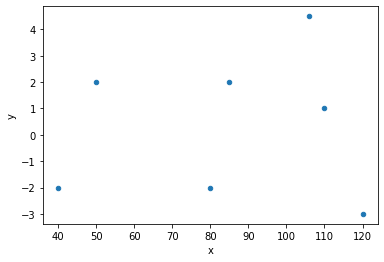

In [12]:
#параметр scatter для графиков рассеяния
data_test.plot(kind='scatter', x='x', y='y')
plt.show()

In [13]:
x_test = data_test['x'].tolist()
y_test = data_test['y'].tolist()
answers_test = []
for point_x, point_y in zip(x_test,y_test):
    euclidean_dist = []
    for cent_x, cent_y in zip(C_x,C_y):  
        dist = ((cent_x - point_x) ** 2 + (cent_y - point_y) ** 2) ** (1/2)
        euclidean_dist.append(dist) 
    answers_test.append(np.argmin(euclidean_dist))
data_test.insert(len(data_test.columns), "Answer", answers_test, False)
data_test.head(7)

,x,y,Answer
1,40,-2.0,0
2,50,2.0,0
3,106,4.5,1
4,85,2.0,1
5,110,1.0,1
6,80,-2.0,1
7,120,-3.0,1


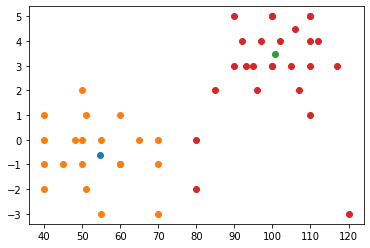

In [14]:
for i in range(2):
    X = data.loc[data['Answer'] == i]['x'].tolist()
    Y = data.loc[data['Answer'] == i]['y'].tolist()
    X += data_test.loc[data_test['Answer'] == i]['x'].tolist()
    Y += data_test.loc[data_test['Answer'] == i]['y'].tolist()
    plt.plot(C_x[i],C_y[i],'o')
    plt.plot(X,Y, 'o')
plt.show()